In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from scipy.stats import ks_2samp
from itertools import combinations
from sklearn.cluster import KMeans

#font 오류 수정
font_list = fm.findSystemFonts()
font_name = None
for font in font_list:
    if 'NanumGothic' in font:
        font_name = fm.FontProperties(fname=font).get_name()
plt.rc('font', family=font_name)


In [6]:
df = pd.read_csv('data/울산_전처리_ver7.csv')

### 1. 단순 EDA
* 접안 대기시간 유무
* 선박 용도별 접안대기 발생 비율
* 선박 용도별 접안 대기시간 평균
* 선박 용도별 대기율(방문순)
* 계선장소별 접안대기 발생비율(상위 10개)
* 상관 분석 Heatmap과 수치

In [4]:
df.columns

Index(['Datetime', 'ETA_Year', 'ETA_Month', 'ETA_Day', 'ETA_Hour', '호출부호',
       '입항일시', '출항일시', '접안_대기시간_분', '출항_대기시간_분', 'Service_Time_Start',
       'Service_Time_End', '계선장소_코드', '계선장소_숫자', '계선장소명', '선박용도',
       'Service_Time_분', '대기율', '총톤수', '재화중량톤수', '선박제원(총길이, m)', '선박제원(너비, m)',
       '만재흘수(m)', '깊이(m)', '길이1(m)', 'ETA_Minute', '풍속(m/s)', '풍향(deg)',
       'GUST풍속(m/s)', '현지기압(hPa)', '습도(%)', '기온(°C)', '수온(°C)', '최대파고(m)',
       '유의파고(m)', '평균파고(m)', '파주기(sec)', '파향(deg)'],
      dtype='object')

##### 접안 대기시간 유무

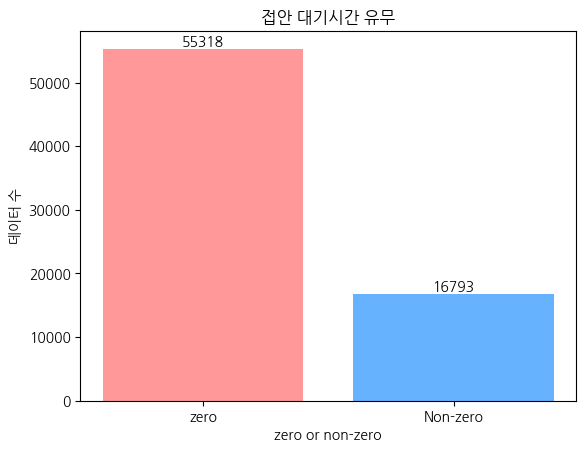

In [11]:
# '접안_대기시간_분' 열이 0인 데이터와 0이 아닌 데이터의 갯수 계산
count_zero = (df['접안_대기시간_분'] == 0).sum()
count_non_zero = (df['접안_대기시간_분'] != 0).sum()

# Pretty colors
colors = ['#FF9999', '#66B2FF']

# 막대 그래프 그리기
bars = plt.bar(['zero', 'Non-zero'], [count_zero, count_non_zero], color=colors)

# 각 막대 위에 숫자 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

plt.title('접안 대기시간 유무')
plt.xlabel('zero or non-zero')
plt.ylabel('데이터 수')
plt.show()


* 전체 입항건 중 20%만 대기를 가지는 것으로 확인

##### 선박용도별 접안 대기시간 발생 비율

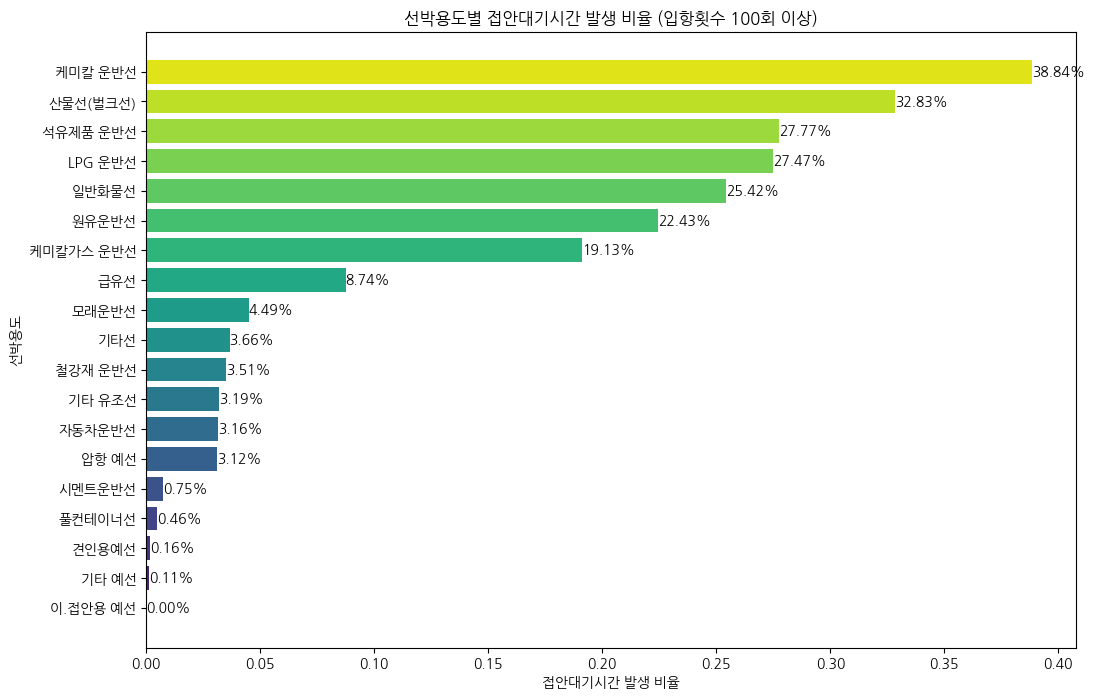

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows with counts less than 100
filtered_df = df.groupby('선박용도').filter(lambda x: len(x) >= 100)

# 선박용도별로 접안대기시간이 발생하는 행의 비율 계산
usage_waiting_rate = filtered_df.groupby('선박용도')['접안_대기시간_분'].apply(lambda x: (x > 0).sum() / len(x)).reset_index()
usage_waiting_rate.columns = ['선박용도', '접안대기시간_발생_비율']

# 내림차순 정렬
usage_waiting_rate = usage_waiting_rate.sort_values(by='접안대기시간_발생_비율', ascending=True)

# 청록색 계열의 색상 설정
colors = sns.color_palette('viridis', len(usage_waiting_rate))

# 수평 막대 그래프 그리기
plt.figure(figsize=(12, 8))
bars = plt.barh(usage_waiting_rate['선박용도'], usage_waiting_rate['접안대기시간_발생_비율'], color=colors)

# 데이터 비율 표시
for bar, rate in zip(bars, usage_waiting_rate['접안대기시간_발생_비율']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{rate:.2%}', ha='left', va='center')

plt.xlabel('접안대기시간 발생 비율')
plt.ylabel('선박용도')
plt.title('선박용도별 접안대기시간 발생 비율 (입항횟수 100회 이상)')
plt.show()


* 여객선과 액체화물선 위주로 대기가 자주 발생하는 것으로 파악

##### 선박 용도별 접안 대기시간 평균

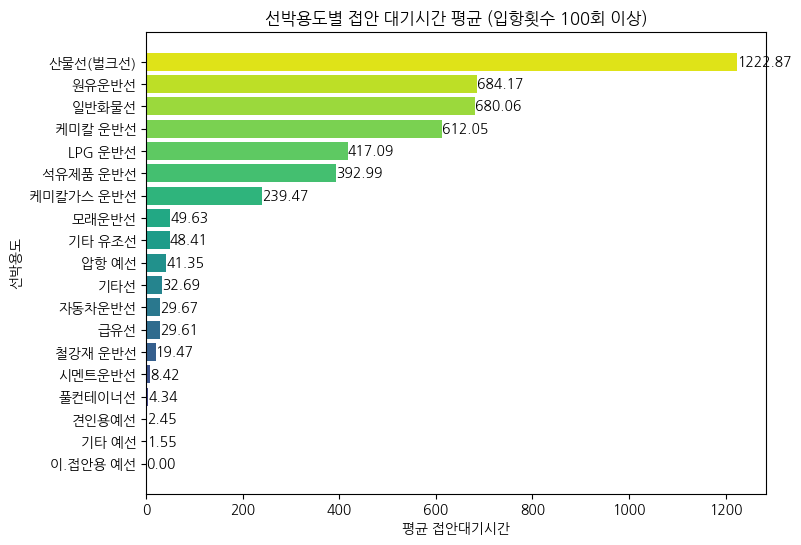

In [3]:
# Filter out rows with counts less than 100
filtered_df = df.groupby('선박용도').filter(lambda x: len(x) >= 100)

# 선박용도별로 접안대기시간 계산
average_wait_time_by_purpose = filtered_df.groupby('선박용도')['접안_대기시간_분'].mean().reset_index()
average_wait_time_by_purpose = average_wait_time_by_purpose.sort_values(by='접안_대기시간_분', ascending=True)

# 청록색 계열의 색상 설정
colors = sns.color_palette('viridis', len(average_wait_time_by_purpose))

# 그래프로 시각화
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.barh(average_wait_time_by_purpose['선박용도'], average_wait_time_by_purpose['접안_대기시간_분'], color=colors)
ax.set_title('선박용도별 접안 대기시간 평균 (입항횟수 100회 이상)')
ax.set_xlabel('평균 접안대기시간')
ax.set_ylabel('선박용도')

# 각 막대 위에 숫자 표시
for bar, value in zip(bars, average_wait_time_by_purpose['접안_대기시간_분']):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{value:.2f}', ha='left', va='center')

plt.show()

##### 선박 용도별 대기율(숫자는 총 입항욋수를 표시)


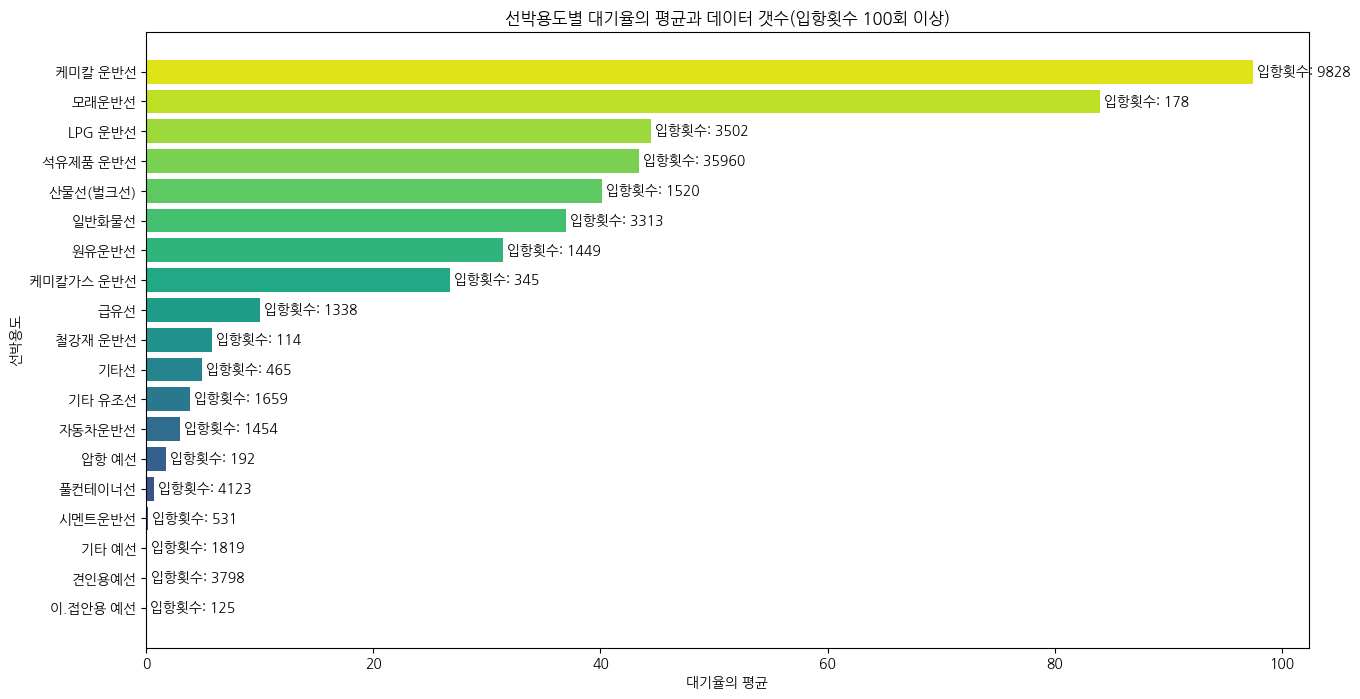

In [3]:
# '선박용도'별 대기율의 평균 및 데이터 갯수 계산
average_waiting_rate_by_purpose = df.groupby('선박용도')['대기율'].agg(['mean', 'count']).reset_index()

# Filter out rows with '입항횟수' less than 100
average_waiting_rate_by_purpose = average_waiting_rate_by_purpose[average_waiting_rate_by_purpose['count'] >= 100]

# 내림차순 정렬
average_waiting_rate_by_purpose = average_waiting_rate_by_purpose.sort_values(by='mean', ascending=True)

# 청록색 계열의 색상 설정
colors = sns.color_palette('viridis', len(average_waiting_rate_by_purpose))

# 큰 크기의 수평 막대 그래프 그리기
plt.figure(figsize=(15, 8))
bars = plt.barh(average_waiting_rate_by_purpose['선박용도'], average_waiting_rate_by_purpose['mean'], color=colors)

# 데이터 갯수 표시
for bar, count in zip(bars, average_waiting_rate_by_purpose['count']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f' 입항횟수: {count}', ha='left', va='center')

plt.xlabel('대기율의 평균')
plt.ylabel('선박용도')
plt.title('선박용도별 대기율의 평균과 데이터 갯수(입항횟수 100회 이상)')
plt.show()

##### 계선 장소별 대기율의 평균 계산

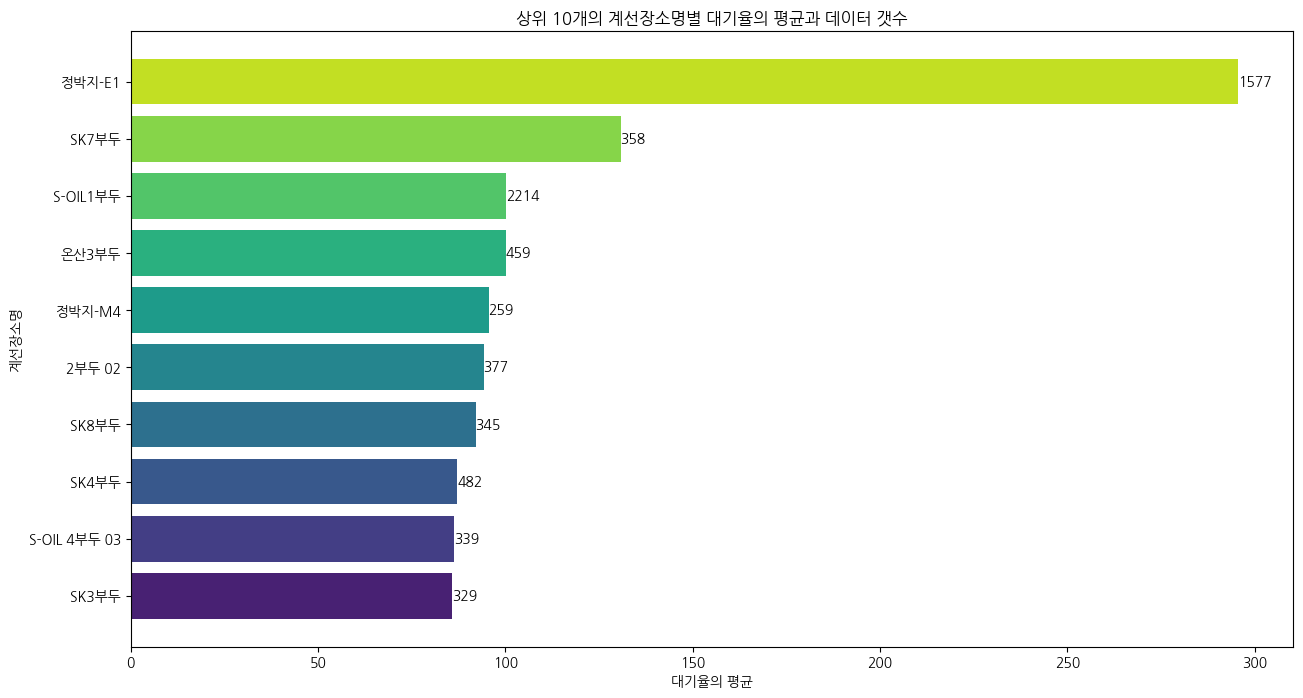

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for color palettes

# '계선장소명'별 대기율의 평균 및 데이터 갯수 계산
waiting_rate_by_location = df.groupby('계선장소명')['대기율'].agg(['mean', 'count']).reset_index()

# 내림차순 정렬
waiting_rate_by_location = waiting_rate_by_location.sort_values(by='mean', ascending=True)

# 상위 10개만 선택
top_10_locations = waiting_rate_by_location.tail(10)

# 청록색 계열의 색상 설정
colors = sns.color_palette('viridis', len(top_10_locations))

# 큰 크기의 수평 막대 그래프 그리기
plt.figure(figsize=(15, 8))  # Adjust the figure size as needed
bars = plt.barh(top_10_locations['계선장소명'], top_10_locations['mean'], color=colors)

# 데이터 갯수 표시
for bar, count in zip(bars, top_10_locations['count']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{count}', ha='left', va='center')

plt.xlabel('대기율의 평균')
plt.ylabel('계선장소명')
plt.title('상위 10개의 계선장소명별 대기율의 평균과 데이터 갯수')

plt.show()


* 액체화물과 관련된 부두가 상위에 랭크
* 정박지-E1은 정보를 찾을 수 없음(임시로 대기하는 곳으로 추정 중)

##### 상관계수 히트맵과 수치

c:\Users\123\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\123\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


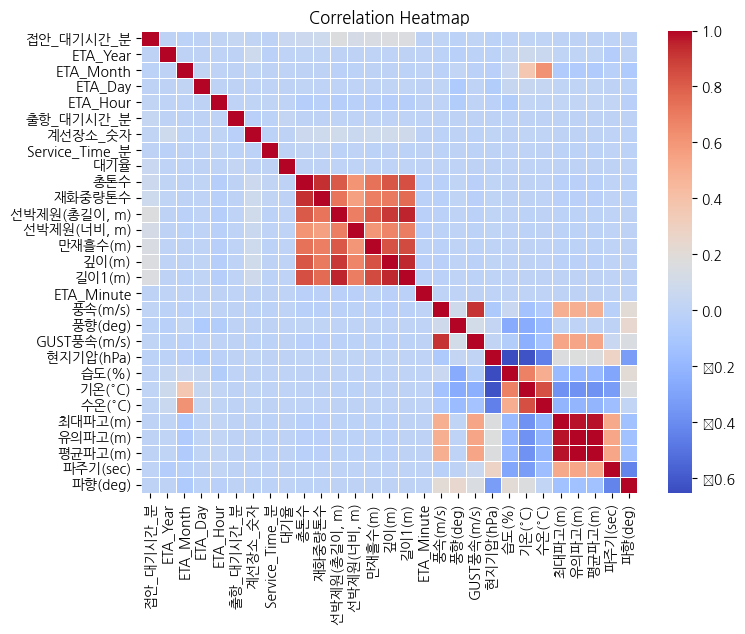

In [5]:
# 숫자로만 구성된 열을 뽑아 새로운 데이터 프레임 생성
new_df = df.select_dtypes(include=['float64', 'int64'])

# 열 재배치
column_order = ['접안_대기시간_분'] + [col for col in new_df if col != '접안_대기시간_분']
new_df = new_df[column_order]

# 상관행렬 생성
correlation_matrix = new_df.corr()

# 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [6]:
# '접안_대기시간_분'과 나머지 열 간의 상관 계수 계산
correlation_with_target = new_df.corr()['접안_대기시간_분'].sort_values(ascending=False)

# 결과 출력
correlation_with_target

접안_대기시간_분         1.000000
선박제원(총길이, m)      0.161283
길이1(m)            0.158373
깊이(m)             0.157293
만재흘수(m)           0.142897
선박제원(너비, m)       0.118933
재화중량톤수            0.077522
총톤수               0.064668
대기율               0.057633
출항_대기시간_분         0.035495
ETA_Hour          0.015513
계선장소_숫자           0.014183
수온(°C)            0.011029
풍속(m/s)           0.010742
기온(°C)            0.008979
GUST풍속(m/s)       0.008531
습도(%)             0.003550
파주기(sec)          0.001172
최대파고(m)          -0.003138
유의파고(m)          -0.003685
평균파고(m)          -0.003873
ETA_Minute       -0.004629
파향(deg)          -0.005125
ETA_Year         -0.005571
Service_Time_분   -0.005901
ETA_Day          -0.006168
현지기압(hPa)        -0.006614
풍향(deg)          -0.007178
ETA_Month        -0.008204
Name: 접안_대기시간_분, dtype: float64

* 액체 / 비액체화물에 대한 상관분석

c:\Users\123\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\123\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


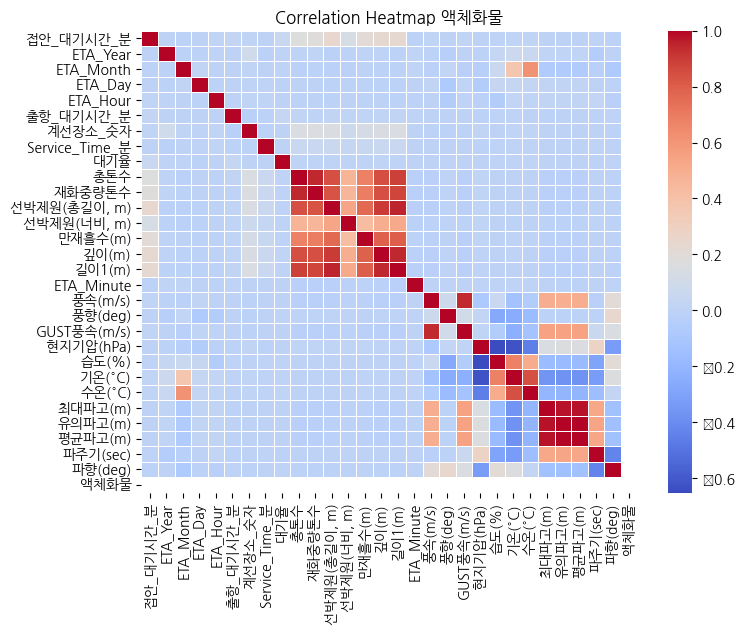

In [12]:
# 액체화물

df_liquid = pd.read_csv('data/액체_모델용.csv')

# 숫자로만 구성된 열을 뽑아 새로운 데이터 프레임 생성
new_df_liquid = df_liquid.select_dtypes(include=['float64', 'int64'])

# 열 재배치
column_order = ['접안_대기시간_분'] + [col for col in new_df_liquid if col != '접안_대기시간_분']
new_df_liquid = new_df_liquid[column_order]

# 상관행렬 생성
correlation_matrix_liquid = new_df_liquid.corr()

# 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_liquid, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap 액체화물')
plt.show()

In [13]:
# '접안_대기시간_분'과 나머지 열 간의 상관 계수 계산
correlation_with_target = new_df_liquid.corr()['접안_대기시간_분'].abs().sort_values(ascending=False)

# 결과 출력
correlation_with_target

접안_대기시간_분         1.000000
선박제원(총길이, m)      0.239318
길이1(m)            0.227872
깊이(m)             0.227296
만재흘수(m)           0.201170
재화중량톤수            0.187390
총톤수               0.169793
선박제원(너비, m)       0.133459
대기율               0.057955
출항_대기시간_분         0.031295
계선장소_숫자           0.011965
풍속(m/s)           0.011746
수온(°C)            0.011540
ETA_Hour          0.010466
GUST풍속(m/s)       0.008983
ETA_Minute        0.008851
ETA_Month         0.008350
기온(°C)            0.007852
파향(deg)           0.007135
평균파고(m)           0.005173
유의파고(m)           0.005007
풍향(deg)           0.004970
최대파고(m)           0.004281
현지기압(hPa)         0.004169
ETA_Year          0.003569
파주기(sec)          0.003508
ETA_Day           0.001609
습도(%)             0.000910
Service_Time_분    0.000181
액체화물                   NaN
Name: 접안_대기시간_분, dtype: float64

c:\Users\123\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\123\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\123\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\123\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

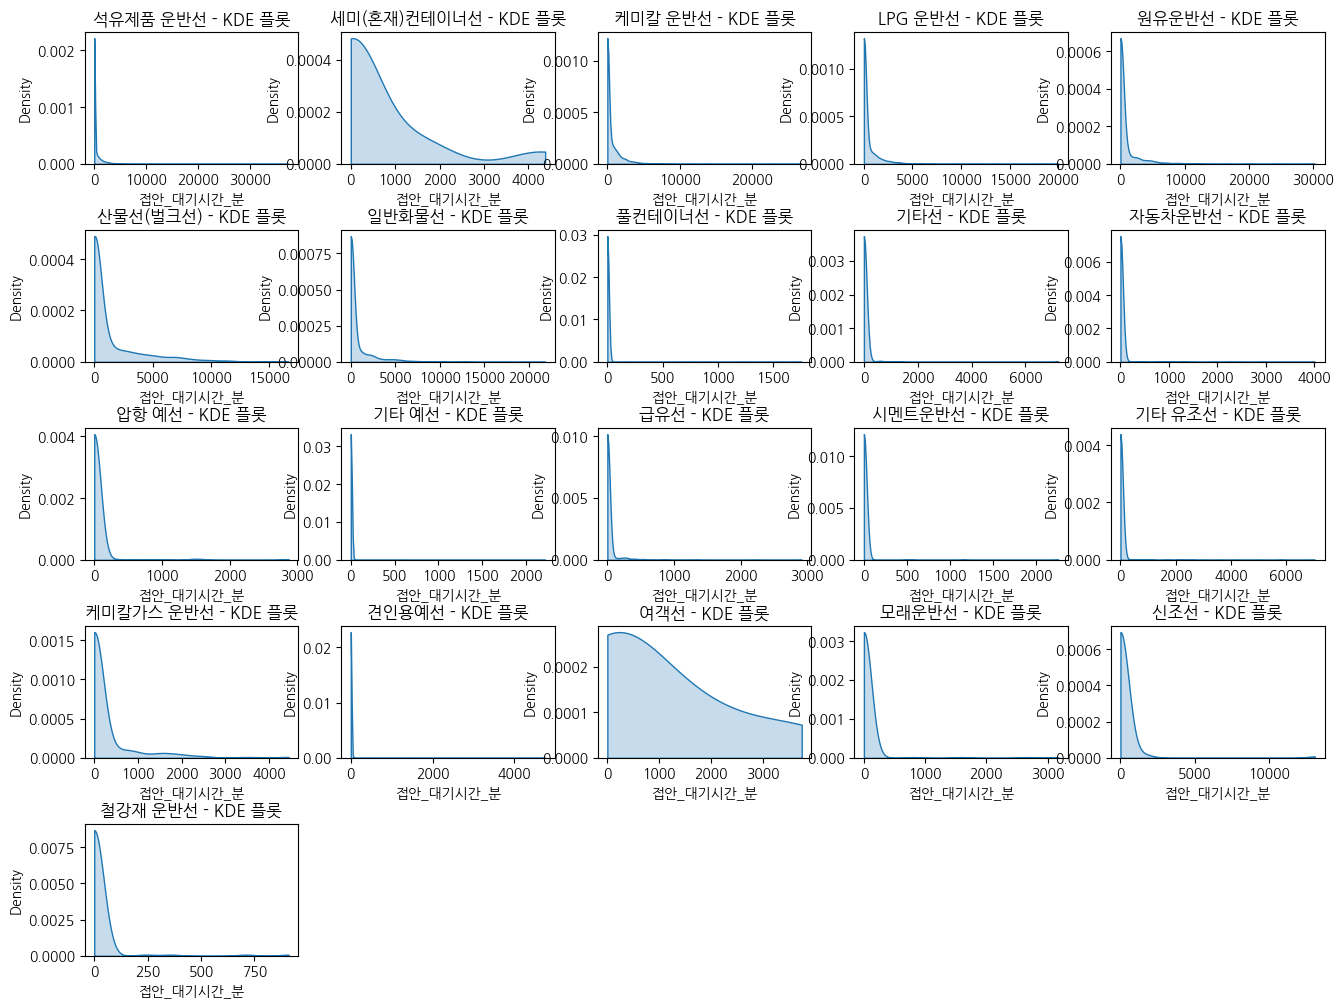

In [11]:
new_df = df[df['접안_대기시간_분'] != 0]

# 선박용도에 따른 접안 대기시간 분포 파악
plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace=0.5)

for i, ship_type in enumerate(new_df['선박용도'].unique(), 1):
    plt.subplot(5, 5, i)
    sns.kdeplot(data=df[df['선박용도'] == ship_type], x='접안_대기시간_분', fill=True, cut = 0)
    plt.title(f'{ship_type} - KDE 플롯')
    plt.xlabel('접안_대기시간_분')
    plt.ylabel('Density')

plt.show()

In [14]:
# '접안_대기시간_분'과 나머지 열 간의 상관 계수 계산
correlation_with_target = new_df_liquid_x.corr()['접안_대기시간_분'].abs().sort_values(ascending=False)

# 결과 출력
correlation_with_target

접안_대기시간_분         1.000000
대기율               0.251726
길이1(m)            0.134673
선박제원(너비, m)       0.127371
선박제원(총길이, m)      0.126258
깊이(m)             0.123556
만재흘수(m)           0.113881
재화중량톤수            0.061949
총톤수               0.044866
출항_대기시간_분         0.042735
ETA_Hour          0.021352
계선장소_숫자           0.018345
ETA_Day           0.013870
평균파고(m)           0.013143
유의파고(m)           0.012851
기온(°C)            0.012849
최대파고(m)           0.012746
ETA_Year          0.011813
풍향(deg)           0.011391
현지기압(hPa)         0.011339
수온(°C)            0.010110
습도(%)             0.008732
파주기(sec)          0.008623
ETA_Month         0.006912
ETA_Minute        0.002762
Service_Time_분    0.002346
파향(deg)           0.000616
GUST풍속(m/s)       0.000445
풍속(m/s)           0.000442
액체화물                   NaN
Name: 접안_대기시간_분, dtype: float64

### 2. 모델링을 위한 선박 분류 시도
* 대기시간 분포의 동일성 확인

c:\Users\123\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\123\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\123\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\123\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

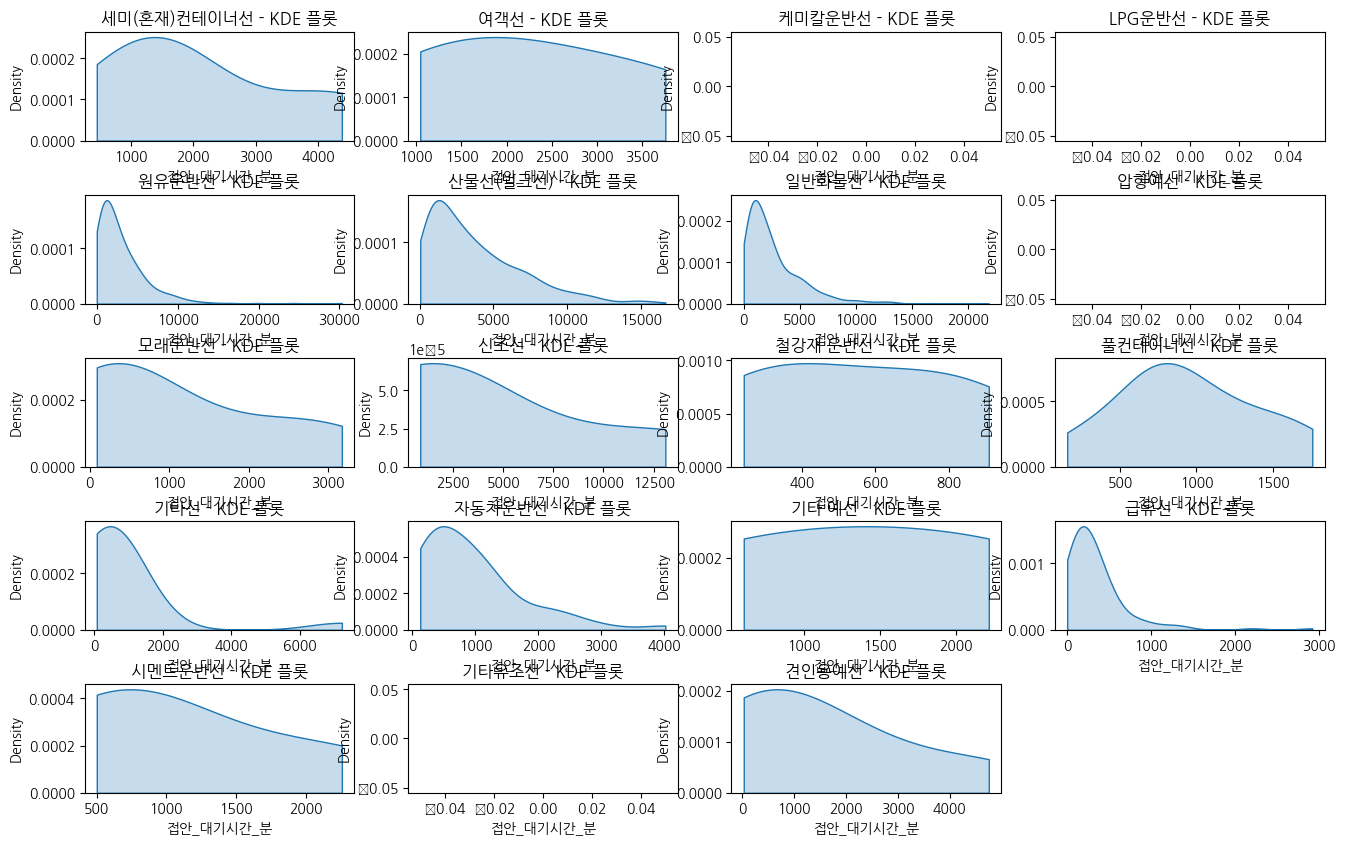

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# 원하는 순서대로 선박용도 정의
desired_ship_order = ['세미(혼재)컨테이너선', '여객선', '케미칼운반선', 'LPG운반선', '원유운반선', '산물선(벌크선)',
                      '일반화물선', '압항예선','모래운반선', '신조선', '철강재 운반선', '풀컨테이너선', '기타선', '자동차운반선', '기타 예선', '급유선', '시멘트운반선', '기타유조선'
                      , '견인용예선']

# 대기시간이 0이 아닌 데이터 추출
new_df = df[df['접안_대기시간_분'] != 0]

# 선박용도에 따른 접안 대기시간 분포 파악
plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace=0.5)

for i, ship_type in enumerate(desired_ship_order, 1):
    plt.subplot(6, 4, i)  # 그래프 숫자에 맞게 조절
    sns.kdeplot(data=new_df[new_df['선박용도'] == ship_type], x='접안_대기시간_분', fill=True, cut=0)
    plt.title(f'{ship_type} - KDE 플롯')
    plt.xlabel('접안_대기시간_분')
    plt.ylabel('Density')

plt.show()


상위 5개 선박용도: ['석유제품 운반선', '케미칼 운반선', '풀컨테이너선', '견인용예선', 'LPG 운반선']


c:\Users\123\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\123\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\123\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


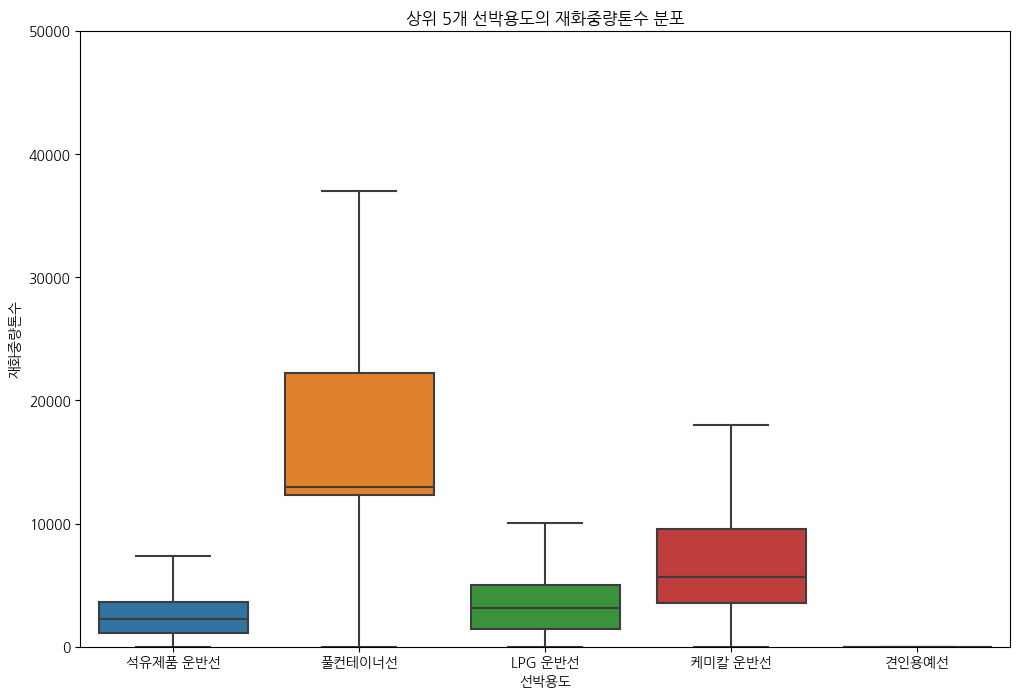

In [8]:
# 선박용도별로 카운팅
top_ship_purposes = df['선박용도'].value_counts().nlargest(5).index.tolist()

# 상위 5개 선박용도 출력
print("상위 5개 선박용도:", top_ship_purposes)

# 선택된 상위 5개 선박용도에 대한 데이터 추출
top_ship_purposes_data = df[df['선박용도'].isin(top_ship_purposes)]

# 박스플롯 그리기
plt.figure(figsize=(12, 8))
sns.boxplot(x='선박용도', y='재화중량톤수', data=top_ship_purposes_data, showfliers=False)  # 이상치 제거
plt.ylim(0, 50000)  # Y축 범위 설정
plt.title('선박용도에 따른 재화중량톤수 분포 (빈도 상위 5종)')
plt.show()